In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import configparser

In [32]:
cfg = configparser.ConfigParser()
cfg.read('settings.conf')
cf_rot = cfg.getfloat('ccd_location', 'rotation')
cf_top = cfg.getint('ccd_location', 'top')
cf_btm = cfg.getint('ccd_location', 'bottom')
cf_stm_left = cfg.getint('ccd_location', 'stm_left')
cf_stm_right = cfg.getint('ccd_location', 'stm_right')
cf_p_left = cfg.getint('ccd_location', 'prep_left')
cf_p_right = cfg.getint('ccd_location', 'prep_right')
cf_thres = cfg.getint('process', 'threshold')

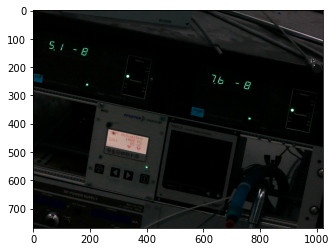

In [33]:
# del(vc)
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1024)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 768)
for i in range(10): _ = cap.read()

rval, frame = cap.read()
import matplotlib.pyplot as plt
plt.imshow(frame)
plt.show()

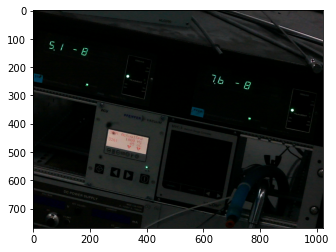

(768, 1024, 3)

In [34]:
vc = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# image = cv2.imread("1.jpg")

vc.set(3, 1024)
vc.set(4, 768)
def get_image():
    ret, im = vc.read()
    return im
for i in range(10):
    temp = vc.read()
image = get_image()
def plot(image):
    # plot the image by pyplotlib
    plt.imshow(image)
    plt.show()

plot(image)
image.shape

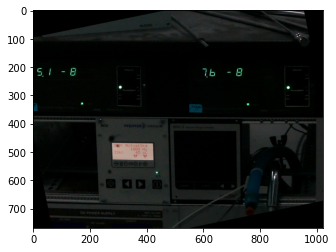

In [35]:
# rotate image by degree
def rotate(image, degree):
    # rotate image by degree
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, degree, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

image = rotate(image, cf_rot)
plot(image)

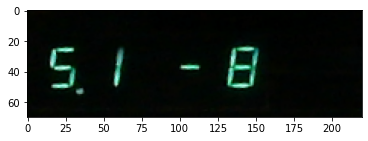

In [36]:
# area_img = image[450:550, 200:350]
area_img = image[cf_top:cf_btm, cf_stm_left:cf_stm_right]
plot(area_img)

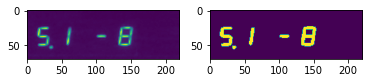

In [37]:
# convert the area_img to gray scale
gray_img = cv2.cvtColor(area_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_img, (3, 3), 0)
plt.subplot(121)
plt.imshow(blurred)
# thres, dst = cv2.threshold(blurred, 170, 255, cv2.THRESH_BINARY)
thres, dst = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY)
plt.subplot(122)
plt.imshow(dst)

7
17.0


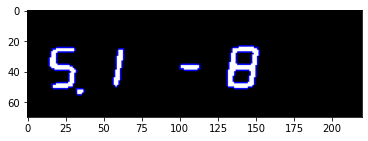

In [38]:
dst = dst.astype(np.uint8)
contours, hierarchy = cv2.findContours(dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
dst_color = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cv2.drawContours(dst_color, contours, -1, (0, 0, 255), 1)
plt.imshow(dst_color)
print(len(contours))
print(cv2.contourArea(contours[0]))

thres: 73.71428571428571
[[[14, 24], [32, 51]], [[56, 25], [63, 50]], [[131, 23], [152, 51]], [[135, 39], [146, 47]], [[137, 27], [148, 35]]]


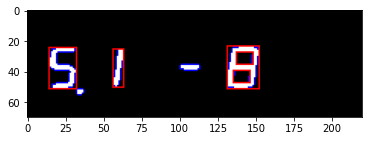

In [39]:
area_list = [cv2.contourArea(i) for i in contours]
thres = np.average(area_list)/2
print("thres:", thres)

def getArea(contour):
    xl, yl = [], []
    for c in contour:
        xl.append(c[0][0])
        yl.append(c[0][1])
    return np.min(xl), np.max(xl), np.min(yl), np.max(yl)

size_chart = []
for i in contours:
    if cv2.contourArea(i) < thres: continue
    xs, xm, ys, ym = getArea(i)
    cv2.rectangle(dst_color, (xs, ys), (xm, ym), (255, 0, 0))
    size_chart.append([[xs, ys], [xm, ym]])

plt.imshow(dst_color)
size_chart = sorted(size_chart, key=lambda x: x[0][0])
print(size_chart)

In [40]:
x_min = dst.shape[0]
x_max = delta_y_max = 0
for i in size_chart:
    x_min = min(i[0][1], x_min)
    x_max = max(i[1][1], x_max)
    dty = i[1][0] - i[0][0]
    delta_y_max = max(delta_y_max, dty)

for i in size_chart:
    i[0][1] = x_min-1
    i[1][1] = x_max+1
    dty_ = delta_y_max - (i[1][0] - i[0][0])
    i[0][0] -= (dty_ - int(dty_/2-1))
    i[1][0] += int(dty_/2+1)

wrapped_print = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
# for item in size_chart:
#     cv2.rectangle(wrapped_print, item[0], item[1], (255, 0, 255), 1)
#     print(item)
# plt.imshow(wrapped_print)

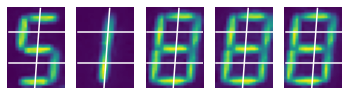

In [41]:
x = 0
sub_data_list = []
for i in size_chart:
    x += 1
    sub_data = gray_img[i[0][1]: i[1][1], i[0][0]: i[1][0]]
    sub_data = cv2.resize(sub_data, (20, 28))
    sub_data_list.append(sub_data)
    plt.subplot(1, len(size_chart), x)
    plt.axis('off')
    plt.plot([11, 9], [0, 28], color='white')
    plt.plot([0, 20], [8, 8], color='white')
    plt.plot([0, 20], [19, 19], color='white')

    plt.imshow(sub_data)

In [42]:
def seven_blocked_test(img):
    # top
    # threshold ~ 0.25 - 0.3
    res = 0b0000_0000
    res = (res | (img[1:5, 5:18].sum()/(255*4*13) > 0.3)) << 1
    res = (res | (img[12:16, 5:14].sum()/(255*4*9) > 0.3)) << 1
    res = (res | (img[23:28, 3:14].sum()/(255*5*11) > 0.3)) << 1
    # left
    res = (res | (img[4:14, 3:8].sum()/(255*10*5) > 0.25)) << 1
    res = (res | (img[16:26, 1:6].sum()/(255*10*5) > 0.25)) << 1
    # right
    res = (res | (img[4:14,  14:20].sum()/(255*10*6) > 0.25)) << 1
    res =  res | (img[16:26,  12:18].sum()/(255*10*6) > 0.25)
    # top, mid, btm, left_up, left_down, right_up, right_down
    print(bin(res))
    return res

In [43]:
def special_one_test(img):
    if img[1: 28, 7: 13].sum()/(255*5*11) > 0.30:
        return 1
    else: return "?"

In [44]:
def get_result_from_code(res):
    # 0: 101_1111, 95
    # 1: 000_0011, 3
    # 2: 111_0110, 118
    # 3: 111_0011, 115
    # 4: 010_1011, 43
    # 5: 111_1001, 121
    # 6: 111_1101, 125
    # 6': 011_1101, 61
    # 7: 100_0011, 67
    # 8: 111_1111, 127
    # 9: 111_1011, 123
    # 9', 110_1011, 107
    # -, 010-0000, 32
    code_ = {95: 0, 3:1, 118:2, 115:3, 43:4, 121:5, 125:6, 61:6, 67:7, 127:8, 123:9, 107:9}
    try: 
        return code_[res]
    except KeyError:
        return special_one_test(img)

0b1111001
0b100000
0b1111111
0b1111111
0b1111111


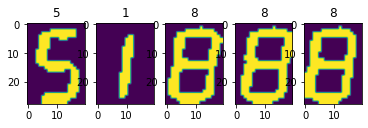

In [45]:
x = 1
for img in sub_data_list:
    # GuassianBlur img
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    # set threshold value 40
    _, img = cv2.threshold(blurred, 70, 255, cv2.THRESH_BINARY)
    # plot the threshold image
    plt.subplot(1, len(sub_data_list), x)
    x += 1
    # plt.axis('off')s
    plt.imshow(img)
    code = seven_blocked_test(img)
    plt.title(get_result_from_code(code))

plt.show()